In [4]:
import os
import librosa
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# Function to augment audio
def augment_audio(y, sr):
    # Add noise
    y_noisy = y + 0.005 * np.random.randn(len(y))

    # Time stretch
    y_stretch = librosa.effects.time_stretch(y, rate=0.8)

    # Correct pitch shift usage
    y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)

    return [y_noisy, y_stretch, y_shift]

# Function to extract MFCC features, modified to accept raw audio data
def extract_mfcc(audio, sr, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features
    mfcc = np.mean(mfcc.T, axis=0)  # Average MFCCs over time to get a single vector
    return mfcc

# Function to load and process audio files from the CREMA-D dataset
def load_crema_d_data(crema_d_path):
    data = []
    labels = []

    for file_name in os.listdir(crema_d_path):
        if file_name.endswith('.wav'):  # Process only .wav files
            # Check if the filename contains 'FEA' for fear or 'ANG' for anger
            emotion = 'fear' if 'FEA' in file_name or 'ANG' in file_name else 'neutral'
            # Assign labels: 0 for fear and anger (dangerous), 1 for other emotions (safe)
            label = 0 if emotion == 'fear' else 1
            # Load the audio file
            file_path = os.path.join(crema_d_path, file_name)
            y, sr = librosa.load(file_path, sr=16000)
            # Extract MFCC features from the audio data
            features = extract_mfcc(y, sr)
            data.append(features)
            labels.append(label)

            # Data augmentation for fear and anger samples (label == 0)
            if label == 0:
                augments = augment_audio(y, sr)
                for aug in augments:
                    # Extract MFCC features directly from augmented data
                    augmented_features = extract_mfcc(aug, sr)
                    data.append(augmented_features)
                    labels.append(label)

    return np.array(data), np.array(labels)

# Path to the CREMA-D dataset
crema_d_path = 'newdata'  # Update with your actual path

# Load data and labels from the CREMA-D dataset
X, y = load_crema_d_data(crema_d_path)

# Count occurrences of each label in y
label_counts = Counter(y)
print(f"Danger Count: {label_counts.get(0, 0)}")
print(f"Safe Count: {label_counts.get(1, 0)}")


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Second split: 80% of the training data for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Reshape data for CNN input
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, 1)


Danger Count: 10168
Safe Count: 4931


In [5]:
from sklearn.utils import resample
import numpy as np

# Combine dangerous and safe data
X_combined = np.concatenate((X[y == 0], X[y == 1]), axis=0)
y_combined = np.concatenate((y[y == 0], y[y == 1]), axis=0)

# Separate safe samples for oversampling
X_safe = X[y == 1]
y_safe = y[y == 1]

# Perform oversampling of safe samples
X_safe_oversampled, y_safe_oversampled = resample(X_safe, y_safe, 
                                                  replace=True,     # Sample with replacement
                                                  n_samples=X_combined[y_combined == 0].shape[0], # Match danger samples
                                                  random_state=42)

# Combine augmented dangerous samples and oversampled safe samples
X_balanced = np.concatenate([X[y == 0], X_safe_oversampled])
y_balanced = np.concatenate([y[y == 0], y_safe_oversampled])


In [6]:
from collections import Counter

# Count occurrences of each label in y_balanced
label_counts_balanced = Counter(y_balanced)

# Print the counts for danger and safe classes
print(f"Danger Count (0): {label_counts_balanced.get(0, 0)}")
print(f"Safe Count (1): {label_counts_balanced.get(1, 0)}")


Danger Count (0): 10168
Safe Count (1): 10168


In [7]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut connection
    shortcut = x

    # Main path: First convolution layer
    x = Conv2D(filters, (kernel_size, kernel_size), strides=stride, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Main path: Second convolution layer
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    # Adjust shortcut to match dimensions of output if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(0.001))(shortcut)
    
    # Add shortcut to the output of the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [8]:
from tensorflow.keras.layers import Add, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Build the model using functional API
input_layer = Input(shape=(X_train_reshaped.shape[1], 1, 1))

# Initial convolutional layer
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 1))(x)

# Add multiple residual blocks with increasing filters
x = residual_block(x, 64)
x = MaxPooling2D(pool_size=(2, 1))(x)

x = residual_block(x, 128)
x = MaxPooling2D(pool_size=(2, 1))(x)

x = residual_block(x, 256)
x = MaxPooling2D(pool_size=(2, 1))(x)

# Flatten and fully connected layers
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model (no class weights as the data is balanced now)
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,  # You may adjust based on validation performance
    batch_size=32,  # Larger batch size could help, but monitor memory usage
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50
284/284 [==============================] - 3s 8ms/step - loss: 1.8429 - accuracy: 0.7344 - val_loss: 1.4594 - val_accuracy: 0.6623 - lr: 1.0000e-04
Epoch 2/50
284/284 [==============================] - 2s 7ms/step - loss: 1.2829 - accuracy: 0.7888 - val_loss: 1.1893 - val_accuracy: 0.8235 - lr: 1.0000e-04
Epoch 3/50
284/284 [==============================] - 2s 7ms/step - loss: 1.1681 - accuracy: 0.8022 - val_loss: 1.0972 - val_accuracy: 0.8242 - lr: 1.0000e-04
Epoch 4/50
284/284 [==============================] - 2s 7ms/step - loss: 1.0965 - accuracy: 0.8112 - val_loss: 1.0520 - val_accuracy: 0.8424 - lr: 1.0000e-04
Epoch 5/50
284/284 [==============================] - 2s 7ms/step - loss: 1.0467 - accuracy: 0.8225 - val_loss: 1.1940 - val_accuracy: 0.7096 - lr: 1.0000e-04
Epoch 6/50
284/284 [==============================] - 2s 7ms/step - loss: 0.9992 - accuracy: 0.8327 - val_loss: 0.9569 - val_accuracy: 0.8570 - lr: 1.0000e-04
Epoch 7/50
284/284 [==========================

In [9]:
model.save('C:/Users/amite/OneDrive/Desktop/finalintel/mainmodel.h5') 

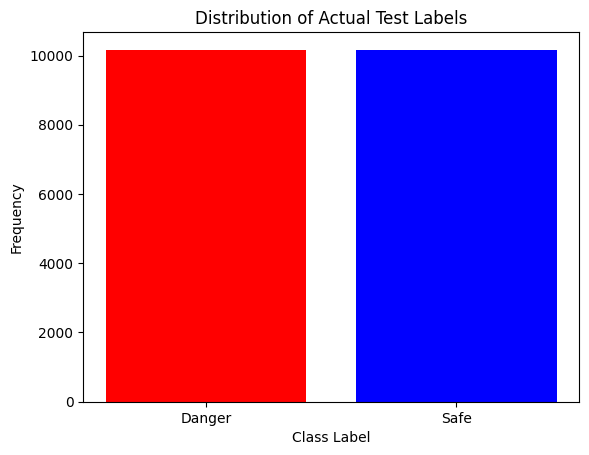

In [12]:
import matplotlib.pyplot as plt

# Visualize the distribution of actual test labels
plt.bar(label_counts_balanced.keys(), label_counts_balanced.values(), color=['red', 'blue'])
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Test Labels')
plt.xticks([0, 1], ['Danger', 'Safe'])
plt.show()

In [7]:
import librosa
import numpy as np
import tensorflow as tf  # For loading the model

# Function to classify an audio file using the trained model
def extract_mfcc(audio, sr, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features
    mfcc = np.mean(mfcc.T, axis=0)  # Average MFCCs over time to get a single vector
    return mfcc

def classify_audio(file_path, model_path):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=16000)  # Adjust sample rate if needed
        
        # Extract MFCC features from the audio data
        mfcc_features = extract_mfcc(y, sr)
        
        # Check the shape of extracted features
        print(f"Extracted MFCC shape: {mfcc_features.shape}")
        
        # Load the trained model
        model = tf.keras.models.load_model(model_path)
        
        # Reshape the features for model input
        # Reshape to (1, 40, 1, 1) to match the model's expected input
        mfcc_features = mfcc_features.reshape(1, 40, 1, 1)
        
        # Check the reshaped input shape
        print(f"Reshaped MFCC shape: {mfcc_features.shape}")
        
        # Make a prediction
        prediction = model.predict(mfcc_features)
        
        # Print prediction values for debugging
        print(f"Prediction: {prediction}")
        
        # Interpret the prediction (assuming binary classification)
        return 'danger' if prediction[0][0] > 0.5 else 'safe'
    
    except Exception as e:
        print(f"Error processing audio file: {e}")
        return "Error"

# Example usage
new_audio_file = 'Recording (28).wav'
model_path = 'mainmodel.h5'
result = classify_audio(new_audio_file, model_path)
print(f'The audio indicates: {result}')

Extracted MFCC shape: (40,)
Reshaped MFCC shape: (1, 40, 1, 1)
1/1 [==============================] - 0s 101ms/step
Prediction: [[0.00518899]]
The audio indicates: safe
